SCARA Total Energy Check

1.5707963267948966 0.0 0
[0. 0. 0. 0. 0. 0.]


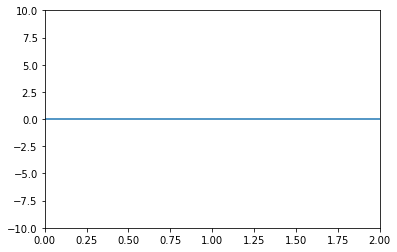

In [ ]:
import math
import numpy as np
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def scara_invkin(x,y,z,d1,d2,d4):
    # using formulae from the textbook
    r = abs((x**2+y**2-d1**2-d2**2)/(2*d1*d2))
    theta2 = math.atan2(np.sqrt(abs(1-r**2)),r)
    theta1 = math.atan2(y,x) - math.atan2((d2*np.sin(theta2)),(d1+d2*np.cos(theta2)))
    d3 = d4-z
    return (theta1, theta2, d3)

A = [2,0,1]
B = [0,2,1]
d1 = 1
d2 = 1
d3 = 1
A_joint_vars = scara_invkin(A[0],A[1],A[2],d1,d2,d3)
B_joint_vars = scara_invkin(B[0],B[1],B[2],d1,d2,d3)
[q1d, q2d, q3d] = B_joint_vars
[q1, q2, q3] = A_joint_vars

print (q1d, q2d, q3d)

Kp1 = 0
Kp2 = 0
Kp3 = 0
Ki1 = 0
Ki2 = 0
Ki3 = 0

tau1 = Kp1*(q1d-q1)+Ki1*(q1d-q1)
tau2 = Kp2*(q2d-q2)+Ki2*(q2d-q2)
tau3 = 9.8+Kp3*(q3d-q3)+Ki3*(q3d-q3)

def func(t,y):
  
  global tau1
  global tau2
  global tau3
  q1 = y[0]
  q2 = y[1]
  q3 = y[2]
  q1dot = y[3]
  q2dot = y[4]
  q3dot = y[5]

  I1 = 1
  I2 = 1
  I3 = 1
  m1 = 1
  m2 = 1
  m3 = 1
  l1 = 1
  l2 = 1

  alpha = I1 + m1*(l1/2)**2 + m2*l1**2 + m3*l1**2
  beta = I2 + I3 + m3*l2**2 + +m2*(l2/2)**2
  gamma = l1*l2*m3 + (m2*l1*l2)/2

  M = np.array([[alpha+beta+2*gamma*np.cos(q2), beta+gamma*np.cos(q2),0],[beta+gamma*np.cos(q2), beta, 0],[0, 0, m3]])
  C = np.array([[-gamma*q2dot*np.sin(q2), -gamma*(q1dot+q2dot)*np.sin(q2), 0],[gamma*q1dot*np.sin(q2), 0, 0], [0, 0, 0]])
  G = np.array([[0],[0],[9.8*m3]])
  torque = np.array([[tau1],[tau2],[tau3]])
  qdot = np.array([[q1dot],[q2dot],[q3dot]])
  qddot = np.linalg.inv(M)@(torque - C@qdot - G)

  dydt = np.vstack((qdot, qddot))

  return dydt

ode = scipy.integrate.ode(func).set_integrator('vode', nsteps=500, method='bdf')

t = 10
dt = 0.01
state = [q1,q2,q3,0,0,0]
error_buffer_q1 = [q1d-q1]+[0]*30
error_buffer_q2 = [q2d-q2]+[0]*30
error_buffer_q3 = [q3d-q3]+[0]*30

q1t = [q1]
q2t = [q2]
q3t = [q3]
q1dt = [0]
q2dt = [0]
q3dt = [0]

m = int(t/dt)
for i in range(0,m):
  i = i/100
  ode.set_initial_value(state,i)
  newstate = ode.integrate(ode.t+dt)
  state = newstate

  error_buffer_q1.pop(len(error_buffer_q1)-1)
  error_buffer_q1.insert(0,q1d-state[0])
  error_buffer_q2.pop(len(error_buffer_q2)-1)
  error_buffer_q2.insert(0,q2d-state[1])
  error_buffer_q3.pop(len(error_buffer_q3)-1)
  error_buffer_q3.insert(0,q3d-state[2])

  tau1 = Kp1*(q1d-state[0]) + Ki1*sum(error_buffer_q1)
  tau2 = Kp2*(q2d-state[1]) + Ki2*sum(error_buffer_q2)
  tau3 = 9.8 + Kp3*(q3d-state[2]) + Ki3*sum(error_buffer_q3)

  q1t.append(state[0])
  q2t.append(state[1])
  q3t.append(state[2])
  q1dt.append(state[3])
  q2dt.append(state[4])
  q3dt.append(state[5])

print(state)

time = np.linspace(0,t,num=int(t/dt)+1)
time = np.reshape(time, (int(t/dt)+1,1))

I1 = 1
I2 = 1
I3 = 1
m1 = 1
m2 = 1
m3 = 1
l1 = 1
l2 = 1

alpha = I1 + m1*(l1/2)**2 + m2*l1**2 + m3*l1**2
beta = I2 + I3 + m3*l2**2 + +m2*(l2/2)**2
gamma = l1*l2*m3 + (m2*l1*l2)/2

total_energy = []

for j in range(0,len(q1dt)):
  q1 = q1t[j]
  q2 = q2t[j]
  q3 = q3t[j]
  q1dot = q1dt[j]
  q2dot = q2dt[j]
  q3dot = q3dt[j]
  qdot = np.array([[q1dot],[q2dot],[q3dot]])
  M = np.array([[alpha+beta+2*gamma*np.cos(q2), beta+gamma*np.cos(q2),0],[beta+gamma*np.cos(q2), beta, 0],[0, 0, m3]])
  K = 0.5*np.transpose(qdot)@M@qdot
  V = m3*9.8*q3
  T = K+V
  total_energy.append(T)

total_energy = np.reshape(total_energy, (1001,1))
time = np.reshape(time, (1001,1))
plt.figure()
plt.plot(time, total_energy)
plt.xlim([0,2])
plt.ylim([-10,10])
plt.show()

PI Tuned SCARA 


1.5707963267948966 0.0 0
[ 1.57062746e+00 -9.78143076e-03  0.00000000e+00  2.47789002e-04
  2.39597009e-03  0.00000000e+00]


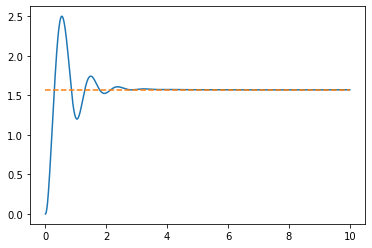

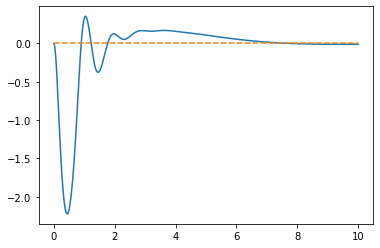

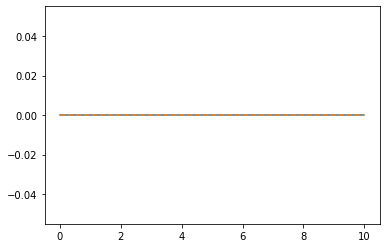

In [ ]:
import math
import numpy as np
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def scara_invkin(x,y,z,d1,d2,d4):
    # using formulae from the textbook
    r = abs((x**2+y**2-d1**2-d2**2)/(2*d1*d2))
    theta2 = math.atan2(np.sqrt(abs(1-r**2)),r)
    theta1 = math.atan2(y,x) - math.atan2((d2*np.sin(theta2)),(d1+d2*np.cos(theta2)))
    d3 = d4-z
    return (theta1, theta2, d3)

A = [2,0,1]
B = [0,2,1]
d1 = 1
d2 = 1
d3 = 1
A_joint_vars = scara_invkin(A[0],A[1],A[2],d1,d2,d3)
B_joint_vars = scara_invkin(B[0],B[1],B[2],d1,d2,d3)
[q1d, q2d, q3d] = B_joint_vars
[q1, q2, q3] = A_joint_vars

print (q1d, q2d, q3d)

Kp1 = 100
Kp2 = 20
Kp3 = 10
Ki1 = -0.9
Ki2 = -0.6
Ki3 = 0

tau1 = Kp1*(q1d-q1)+Ki1*(q1d-q1)
tau2 = Kp2*(q2d-q2)+Ki2*(q2d-q2)
tau3 = 9.8+Kp3*(q3d-q3)+Ki3*(q3d-q3)

def func(t,y):
  
  global tau1
  global tau2
  global tau3
  q1 = y[0]
  q2 = y[1]
  q3 = y[2]
  q1dot = y[3]
  q2dot = y[4]
  q3dot = y[5]

  I1 = 1
  I2 = 1
  I3 = 1
  m1 = 1
  m2 = 1
  m3 = 1
  l1 = 1
  l2 = 1

  alpha = I1 + m1*(l1/2)**2 + m2*l1**2 + m3*l1**2
  beta = I2 + I3 + m3*l2**2 + +m2*(l2/2)**2
  gamma = l1*l2*m3 + (m2*l1*l2)/2

  M = np.array([[alpha+beta+2*gamma*np.cos(q2), beta+gamma*np.cos(q2),0],[beta+gamma*np.cos(q2), beta, 0],[0, 0, m3]])
  C = np.array([[-gamma*q2dot*np.sin(q2), -gamma*(q1dot+q2dot)*np.sin(q2), 0],[gamma*q1dot*np.sin(q2), 0, 0], [0, 0, 0]])
  G = np.array([[0],[0],[9.8*m3]])
  torque = np.array([[tau1],[tau2],[tau3]])
  qdot = np.array([[q1dot],[q2dot],[q3dot]])
  qddot = np.linalg.inv(M)@(torque - C@qdot - G)

  dydt = np.vstack((qdot, qddot))

  return dydt

ode = scipy.integrate.ode(func).set_integrator('vode', nsteps=500, method='bdf')

t = 10
dt = 0.01
state = [q1,q2,q3,0,0,0]
error_buffer_q1 = [q1d-q1]+[0]*30
error_buffer_q2 = [q2d-q2]+[0]*30
error_buffer_q3 = [q3d-q3]+[0]*30

q1t = [q1]
q2t = [q2]
q3t = [q3]
q1dt = [0]
q2dt = [0]
q3dt = [0]

m = int(t/dt)
for i in range(0,m):
  i = i/100
  ode.set_initial_value(state,i)
  newstate = ode.integrate(ode.t+dt)
  state = newstate

  error_buffer_q1.pop(len(error_buffer_q1)-1)
  error_buffer_q1.insert(0,q1d-state[0])
  error_buffer_q2.pop(len(error_buffer_q2)-1)
  error_buffer_q2.insert(0,q2d-state[1])
  error_buffer_q3.pop(len(error_buffer_q3)-1)
  error_buffer_q3.insert(0,q3d-state[2])

  tau1 = Kp1*(q1d-state[0]) + Ki1*sum(error_buffer_q1)
  tau2 = Kp2*(q2d-state[1]) + Ki2*sum(error_buffer_q2)
  tau3 = 9.8 + Kp3*(q3d-state[2]) + Ki3*sum(error_buffer_q3)

  q1t.append(state[0])
  q2t.append(state[1])
  q3t.append(state[2])
  q1dt.append(state[3])
  q2dt.append(state[4])
  q3dt.append(state[5])

print(state)

time = np.linspace(0,t,num=int(t/dt)+1)
time = np.reshape(time, (int(t/dt)+1,1))
plt.figure()
plt.plot(time, q1t)
plt.plot(time,[q1d]*1001, linestyle="dashed")
plt.show()
plt.figure()
plt.plot(time, q2t)
plt.plot(time,[q2d]*1001, linestyle="dashed")
plt.show()
plt.figure()
plt.plot(time, q3t)
plt.plot(time,[q3d]*1001, linestyle="dashed")
plt.show()

PUMA Total Energy Check

singular configuration
singular configuration
1.5707963267948966 0.0 -0.0
[ 0.         -1.72488511 -0.11163836  0.          3.31224326  0.00726587]


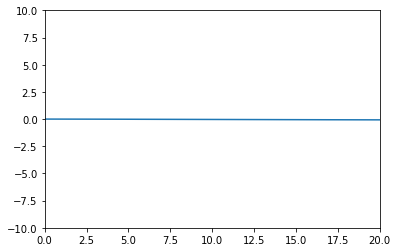

In [3]:
import math
import numpy as np
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def inverse_kinematics_puma(l1,l2,l3,xc,yc,zc):
    theta1 = (math.atan2(yc,xc))
    D = (xc*xc+yc*yc+(l1-zc)*(l1-zc)-l2*l2-l3*l3)/(2*l2*l3)
    if D==1 or D==-1:
        print("singular configuration")
    if D>1 or D<-1:
        print("outside workspace")
    theta3 = (math.atan2((-math.sqrt(1-D*D)),D))
    theta2 = (math.atan2(zc-l1,(math.sqrt(xc*xc+yc*yc)))-math.atan2((l3*math.sin(theta3)),(l2+l3*math.cos(theta3))))
    return (theta1,theta2,theta3)

A = [2,0,1]
B = [0,2,1]
d1 = 1
d2 = 1
d3 = 1
A_joint_vars = inverse_kinematics_puma(d1,d2,d3,A[0],A[1],A[2])
B_joint_vars = inverse_kinematics_puma(d1,d2,d3,B[0],B[1],B[2])
[q1d, q2d, q3d] = B_joint_vars
[q1, q2, q3] = A_joint_vars

print (q1d, q2d, q3d)

Kp1 = 0
Kp2 = 0
Kp3 = 0
Ki1 = 0
Ki2 = 0
Ki3 = 0

tau1 = Kp1*(q1d-q1)+Ki1*(q1d-q1)
tau2 = Kp2*(q2d-q2)+Ki2*(q2d-q2)
tau3 = Kp3*(q3d-q3)+Ki3*(q3d-q3)

def func(t,y):
  
  global tau1
  global tau2
  global tau3
  q1 = y[0]
  q2 = y[1]
  q3 = y[2]
  q1dot = y[3]
  q2dot = y[4]
  q3dot = y[5]
  
  m1 = 1
  m2 = 1
  m3 = 1
  l1 = 1
  l2 = 1
  I1 = 1
  I2 = 1
  I3 = 1

  a1 = m2*(l1/2)**2 + m3*l1**2
  a2 = m3*(l2/2)**2
  a3 = m3*l1*l2/2
  b1 = 9.8*(m2*(l1/2)+m3*l1)
  b2 = 9.8*m3*l2/2

  m11 = a1*(np.cos(q2))**2 + a2*(np.cos(q2+q3))**2 + 2*a3*np.cos(q2)*np.cos(q2+q3) + I1
  m22 = a1 + a2 + 2*a3*np.cos(q3) + I2
  m33 = a2 + I3
  m23 = a2 + a3*np.cos(q3)
  m32 = m23

  M = np.array([[m11, 0, 0],[0, m22, m23],[0, m32, m33]])

  b11 = -0.5*a1*q2dot*np.sin(2*q2)-0.5*a2*(q2dot+q3dot)*np.sin(2*(q2+q3))-a3*q2dot*np.sin(2*q2+q3)-a3*q3dot*np.cos(q2)*np.sin(q2+q3)
  b12 = -0.5*a1*q1dot*np.sin(2*q2)-0.5*a2*q1dot*np.sin(2*(q2+q3))-a3*q1dot*np.sin(2*q2+q3)
  b13 = -0.5*a2*q1dot*np.sin(2*(q2+q3))-a3*q1dot*np.cos(q2)*np.sin(q2+q3)
  b21 = -b12
  b22 = -a3*q3dot*np.sin(q3)
  b23 = -a3*(q2dot+q3dot)*np.sin(q3)
  b31 = -b13
  b32 = a3*q2dot*np.sin(q3)
  b33 = 0

  B = np.array([[b11, b12, b13], [b21, b22, b23], [b31, b32, b33]])
  f = np.array([[0],[b1*np.cos(q2)+b2*np.cos(q2+q3)],[b2*np.cos(q2+q3)]])
  torque = np.array([[tau1],[tau2],[tau3]])
  qdot = np.array([[q1dot],[q2dot],[q3dot]])
  qddot = np.linalg.inv(M)@(torque-B@qdot-f)
  dydt = np.vstack((qdot, qddot))
  return dydt

ode = scipy.integrate.ode(func).set_integrator('vode', nsteps=500, method='bdf')

t = 20
dt = 0.01
state = [q1,q2,q3,0,0,0]
error_buffer_q1 = [q1d-q1]+[0]*29
error_buffer_q2 = [q2d-q2]+[0]*29
error_buffer_q3 = [q3d-q3]+[0]*29

q1t = [q1]
q2t = [q2]
q3t = [q3]
q1dt = [0]
q2dt = [0]
q3dt = [0]

m = int(t/dt)
for i in range(0,m):
  i = i/100
  ode.set_initial_value(state,i)
  newstate = ode.integrate(ode.t+dt)
  state = newstate

  error_buffer_q1.pop(len(error_buffer_q1)-1)
  error_buffer_q1.insert(0,q1d-state[0])
  error_buffer_q2.pop(len(error_buffer_q2)-1)
  error_buffer_q2.insert(0,q2d-state[1])
  error_buffer_q3.pop(len(error_buffer_q3)-1)
  error_buffer_q3.insert(0,q3d-state[2])

  tau1 = Kp1*(q1d-state[0]) + Ki1*sum(error_buffer_q1)
  tau2 = Kp2*(q2d-state[1]) + Ki2*sum(error_buffer_q2)
  tau3 = Kp3*(q3d-state[2]) + Ki3*sum(error_buffer_q3)

  q1t.append(state[0])
  q2t.append(state[1])
  q3t.append(state[2])
  q1dt.append(state[3])
  q2dt.append(state[4])
  q3dt.append(state[5])

print(state)

m1 = 1
m2 = 1
m3 = 1
l1 = 1
l2 = 1
I1 = 1
I2 = 1
I3 = 1

a1 = m2*(l1/2)**2 + m3*l1**2
a2 = m3*(l2/2)**2
a3 = m3*l1*l2/2
b1 = 9.8*(m2*(l1/2)+m3*l1)
b2 = 9.8*m3*l2/2

total_energy = []
time = np.linspace(0,t,num=int(t/dt)+1)

for j in range(0,len(q1dt)):
  q1 = q1t[j]
  q2 = q2t[j]
  q3 = q3t[j]
  q1dot = q1dt[j]
  q2dot = q2dt[j]
  q3dot = q3dt[j]
  qdot = np.array([[q1dot],[q2dot],[q3dot]])

  m11 = a1*(np.cos(q2))**2 + a2*(np.cos(q2+q3))**2 + 2*a3*np.cos(q2)*np.cos(q2+q3) + I1
  m22 = a1 + a2 + 2*a3*np.cos(q3) + I2
  m33 = a2 + I3
  m23 = a2 + a3*np.cos(q3)
  m32 = m23

  M = np.array([[m11, 0, 0],[0, m22, m23],[0, m32, m33]])
  
  K = 0.5*np.transpose(qdot)@M@qdot
  V = b1*np.sin(q2)+b2*np.sin(q2+q3)
  T = K+V
  total_energy.append(T)

total_energy = np.reshape(total_energy, (2001,1))
time = np.reshape(time, (2001,1))
plt.figure()
plt.plot(time, total_energy)
plt.xlim([0,20])
plt.ylim([-10,10])
plt.show()

PI Tuned PUMA


singular configuration
singular configuration
1.5707963267948966 0.0 -0.0
[ 1.57079633e+00 -4.77444413e-02 -5.42915960e-02 -1.81572326e-14
  2.89586366e-02 -5.17010464e-02]


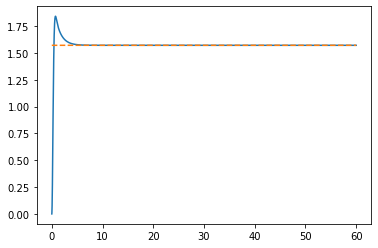

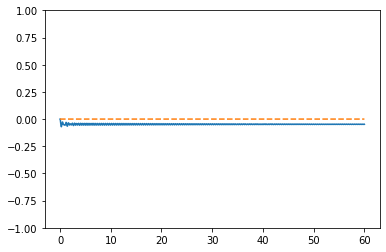

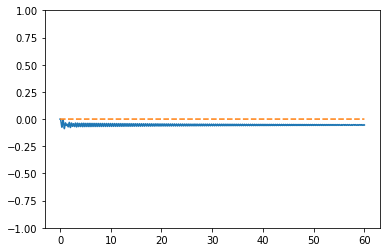

In [7]:
import math
import numpy as np
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def inverse_kinematics_puma(l1,l2,l3,xc,yc,zc):
    theta1 = (math.atan2(yc,xc))
    D = (xc*xc+yc*yc+(l1-zc)*(l1-zc)-l2*l2-l3*l3)/(2*l2*l3)
    if D==1 or D==-1:
        print("singular configuration")
    if D>1 or D<-1:
        print("outside workspace")
    theta3 = (math.atan2((-math.sqrt(1-D*D)),D))
    theta2 = (math.atan2(zc-l1,(math.sqrt(xc*xc+yc*yc)))-math.atan2((l3*math.sin(theta3)),(l2+l3*math.cos(theta3))))
    return (theta1,theta2,theta3)

A = [2,0,1]
B = [0,2,1]
d1 = 1
d2 = 1
d3 = 1
A_joint_vars = inverse_kinematics_puma(d1,d2,d3,A[0],A[1],A[2])
B_joint_vars = inverse_kinematics_puma(d1,d2,d3,B[0],B[1],B[2])
[q1d, q2d, q3d] = B_joint_vars
[q1, q2, q3] = A_joint_vars

print (q1d, q2d, q3d)

Kp1 = 100
Kp2 = 500
Kp3 = 180
Ki1 = -3
Ki2 = -3
Ki3 = -3

tau1 = Kp1*(q1d-q1)+Ki1*(q1d-q1)
tau2 = Kp2*(q2d-q2)+Ki2*(q2d-q2)
tau3 = Kp3*(q3d-q3)+Ki3*(q3d-q3)

def func(t,y):
  
  global tau1
  global tau2
  global tau3
  q1 = y[0]
  q2 = y[1]
  q3 = y[2]
  q1dot = y[3]
  q2dot = y[4]
  q3dot = y[5]
  
  m1 = 1
  m2 = 1
  m3 = 1
  l1 = 1
  l2 = 1
  I1 = 1
  I2 = 1
  I3 = 1

  a1 = m2*(l1/2)**2 + m3*l1**2
  a2 = m3*(l2/2)**2
  a3 = m3*l1*l2/2
  b1 = 9.8*(m2*(l1/2)+m3*l1)
  b2 = 9.8*m3*l2/2

  m11 = a1*(np.cos(q2))**2 + a2*(np.cos(q2+q3))**2 + 2*a3*np.cos(q2)*np.cos(q2+q3) + I1
  m22 = a1 + a2 + 2*a3*np.cos(q3) + I2
  m33 = a2 + I3
  m23 = a2 + a3*np.cos(q3)
  m32 = m23

  M = np.array([[m11, 0, 0],[0, m22, m23],[0, m32, m33]])

  b11 = -0.5*a1*q2dot*np.sin(2*q2)-0.5*a2*(q2dot+q3dot)*np.sin(2*(q2+q3))-a3*q2dot*np.sin(2*q2+q3)-a3*q3dot*np.cos(q2)*np.sin(q2+q3)
  b12 = -0.5*a1*q1dot*np.sin(2*q2)-0.5*a2*q1dot*np.sin(2*(q2+q3))-a3*q1dot*np.sin(2*q2+q3)
  b13 = -0.5*a2*q1dot*np.sin(2*(q2+q3))-a3*q1dot*np.cos(q2)*np.sin(q2+q3)
  b21 = -b12
  b22 = -a3*q3dot*np.sin(q3)
  b23 = -a3*(q2dot+q3dot)*np.sin(q3)
  b31 = -b13
  b32 = a3*q2dot*np.sin(q3)
  b33 = 0

  B = np.array([[b11, b12, b13], [b21, b22, b23], [b31, b32, b33]])
  f = np.array([[0],[b1*np.cos(q2)+b2*np.cos(q2+q3)],[b2*np.cos(q2+q3)]])
  torque = np.array([[tau1],[tau2],[tau3]])
  qdot = np.array([[q1dot],[q2dot],[q3dot]])
  qddot = np.linalg.inv(M)@(torque-B@qdot-f)
  dydt = np.vstack((qdot, qddot))
  return dydt

ode = scipy.integrate.ode(func).set_integrator('vode', nsteps=500, method='bdf')

t = 60
dt = 0.01
state = [q1,q2,q3,0,0,0]
error_buffer_q1 = [q1d-q1]+[0]*29
error_buffer_q2 = [q2d-q2]+[0]*29
error_buffer_q3 = [q3d-q3]+[0]*29

q1t = [q1]
q2t = [q2]
q3t = [q3]
q1dt = [0]
q2dt = [0]
q3dt = [0]

m = int(t/dt)
for i in range(0,m):
  i = i/100
  ode.set_initial_value(state,i)
  newstate = ode.integrate(ode.t+dt)
  state = newstate

  error_buffer_q1.pop(len(error_buffer_q1)-1)
  error_buffer_q1.insert(0,q1d-state[0])
  error_buffer_q2.pop(len(error_buffer_q2)-1)
  error_buffer_q2.insert(0,q2d-state[1])
  error_buffer_q3.pop(len(error_buffer_q3)-1)
  error_buffer_q3.insert(0,q3d-state[2])

  tau1 = Kp1*(q1d-state[0]) + Ki1*sum(error_buffer_q1)
  tau2 = Kp2*(q2d-state[1]) + Ki2*sum(error_buffer_q2)
  tau3 = Kp3*(q3d-state[2]) + Ki3*sum(error_buffer_q3)

  q1t.append(state[0])
  q2t.append(state[1])
  q3t.append(state[2])
  q1dt.append(state[3])
  q2dt.append(state[4])
  q3dt.append(state[5])

print(state)

time = np.linspace(0,t,num=int(t/dt)+1)
time = np.reshape(time, (int(t/dt)+1,1))
plt.figure()
plt.plot(time, q1t)
plt.plot(time,[q1d]*6001, linestyle="dashed")
plt.show()
plt.figure()
plt.plot(time, q2t)
plt.plot(time,[q2d]*6001, linestyle="dashed")
plt.ylim([-1,1])
plt.show()
plt.figure()
plt.plot(time, q3t)
plt.plot(time,[q3d]*6001, linestyle="dashed")
plt.ylim([-1,1])
plt.show()